In [1]:
import time

import tensorflow as tf
from tensorflow.contrib import rnn

import numpy as np
from sklearn.metrics import r2_score

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20, 16)

print("Package is ready.")

Package is ready.


In [2]:
# Load them!
l = np.load("./Data/ECtrainset_wRWEC.npz")

# See what's in here
print (l.files)

# get data
train_data = l['traindataset']
train_label = l['trainlabel']
test_data = l['testdataset']
test_label = l['testlabel']

mins = l['mins']
maxs = l['maxs']

labelmins = l['labelmins']
labelmaxs = l['labelmaxs']

explanation = "RWEC_GRU"
DELETE = [4,5,11,12]
EX_PRED = 0.680548 #Sorry, it's not automated yet.

train_data = np.delete(train_data, DELETE, axis=1)
test_data = np.delete(test_data, DELETE, axis=1)
train_label = train_label[:,:]
test_label = test_label[:,:]

print(train_data[:5])
print(train_label[:5])
print(test_data[:5])
print(test_label[:5])

print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

['maxs', 'trainlabel', 'testdataset', 'mins', 'labelmaxs', 'labelmins', 'traindataset', 'testlabel']
[[ 0.32567992  0.50084235  0.20491604  0.48089765  0.92516063  0.78223629
   0.55528701  0.42583577  0.06756757  0.1855959   0.48086426  0.36363636
   0.52895695  0.14888828  0.23222229  0.24793388]
 [ 0.33018636  0.48709495  0.25655674  0.26491767  0.92931601  0.82019292
   0.45507889  0.35457283  0.06756757  0.23956612  0.26476511  0.36363636
   0.58277116  0.07926687  0.23222229  0.30664601]
 [ 0.32754387  0.39184369  0.24740103  0.480947    0.904194    0.83032818
   0.55135952  0.43005518  0.06756757  0.2554854   0.48090275  0.36363636
   0.64832338  0.03440592  0.23222229  0.30991736]
 [ 0.32294789  0.37715523  0.25419894  0.49524414  0.89576271  0.80197632
   0.55135952  0.43005518  0.06756757  0.2554854   0.49513653  0.36363636
   0.68042326  0.          0.23222229  0.30991736]
 [ 0.32487844  0.37766854  0.2574289   0.51254409  0.90079292  0.7841957
   0.55135952  0.43005518  0.0

In [3]:
#Data setting
n_train = train_label.shape[0]
n_test = test_label.shape[0]
n_input = train_data.shape[1]
n_output = test_label.shape[1]
n_classes = n_output

print("# train: %d # test: %d, # input: %d, # output: %d" % (n_train, n_test, n_input, n_output))


# train: 1200 # test: 456, # input: 16, # output: 18


In [4]:
# Parameters
learning_rate = 0.001
training_epochs = 10000
batch_size = 1200
display_step = 500

# Network Parameters
n_steps = 30 # 1.5 day
n_hidden = 64 # hidden layer num of features

# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_output])

# Define weights
weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_output]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_output]))
}

print("parameters are ready")

parameters are ready


In [5]:
# Load them!
l = np.load("./Data/ECpredset_wRWEC.npz")

# See what's in here
print (l.files)

# get data
pred_data = l['preddataset']
pred_label = l['predlabel']
n_pred = pred_label.shape[0]

print(pred_data[0])
print(pred_label[0])

print(pred_data.shape)
print(pred_label.shape)

#Processing

for i in range(pred_data.shape[1]):
    temp = pred_data[:,i]
    temp = (temp - mins[i]) / (maxs[i] - mins[i])
    pred_data[:,i] = temp

    
for i in range(pred_label.shape[1]):
    temp = pred_label[:,i]
    temp = (temp - labelmins[i]) / (labelmaxs[i] - labelmins[i])
    pred_label[:,i] = temp
    
pred_data = np.delete(pred_data, DELETE, axis=1)

pred_x = pred_data.reshape((-1, n_steps, n_input))

['predlabel', 'preddataset']
[   4.509825      2.36598889    3.63195556   16.15047222   19.63758333
   13.21697222   67.13763889    4.470975      1.768         1.382         0.
    6.36231111    4.28258333    5.374425      5.23260278  150.
  408.34777778    0.           30.           12.355     ]
[ 4.48515278  4.46378611  4.44831667  4.42421667  4.40596667  4.37809167
  4.58665556  4.85048889  4.90490833  4.97277778  4.90884722  4.83730833
  4.75139167  4.71204167  4.66605556  4.62548056  4.5976      4.554325  ]
(3600, 20)
(120, 18)


In [6]:
def RNN(x, weights, biases):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)
    
    # Unstack to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, n_steps, 1)

    # Define a lstm cell with tensorflow
    lstm_cell = rnn.GRUCell(n_hidden)

    # Get lstm cell output
    outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

pred = RNN(x, weights, biases)

print("parameters are ready")

parameters are ready


In [7]:
# Define loss and optimizer
cost = tf.multiply(tf.reduce_sum(tf.square(tf.subtract(pred, y))),1/batch_size)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
ymean = tf.reduce_mean(y)
SSE = tf.reduce_sum(tf.square(tf.subtract(y, pred)))
SSR = tf.reduce_sum(tf.square(tf.subtract(pred, ymean)))
r_squared = SSR/(SSE+SSR)
                                
accuracy = r_squared
# Initializing the variables
init = tf.global_variables_initializer()
saver = tf.train.Saver()

# Do some optimizations
sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth =True)))
sess.run(init)

print("seesion start")

seesion start


In [8]:
# Summary writer
tf.summary.scalar('RMS', cost)
tf.summary.scalar('accuracy', accuracy)
merged = tf.summary.merge_all()
directory_name = "./tb_logs/" + explanation + str(n_hidden)
summary_writer = tf.summary.FileWriter(directory_name, graph=sess.graph)
print ("Summary ready")

Summary ready


In [9]:
# #Previous model restore
# #ACTIVATE AFTER ONE OR MORE TRAINING 
# bestpath = "./models/best_trained_" + explanation + ".ckpt"
# saver.restore(sess, bestpath)

In [10]:
# Launch the graph
num_data = train_data.shape[0]
ex_pred_acc = EX_PRED

# Keep training until reach max iterations
start = time.time()

for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(num_data/batch_size/n_steps)

    for i in range(total_batch):
        batch_x = train_data[i:i+n_steps*batch_size, :]
        batch_y = train_label[i:i+batch_size, :]
        
        # Reshape data
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        # Run optimization op (backprop)
        summary, _ = sess.run([merged, optimizer], feed_dict={x: batch_x, y: batch_y})
        avg_cost += sess.run(cost, feed_dict={x: batch_x, y: batch_y})/total_batch
        summary_writer.add_summary(summary, epoch*total_batch+i)
        
        pred_acc = sess.run(accuracy, feed_dict={x: pred_x, y: pred_label})

    if pred_acc > ex_pred_acc:
        bestpath = "./models/best_trained_" + explanation + ".ckpt"
        save_path = saver.save(sess, bestpath)
        ex_pred_acc = pred_acc
        
    if epoch % display_step == 0:
        print ("Epoch: %04d/%04d cost: %.6f, best: %.3f" % (epoch, training_epochs, avg_cost,ex_pred_acc))
        train_acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})

        test_x = test_data.reshape((-1, n_steps, n_input))
        test_acc = sess.run(accuracy, feed_dict={x: test_x, y: test_label})
        pred_acc = sess.run(accuracy, feed_dict={x: pred_x, y: pred_label})
        print ("Training Acc: %.3f, Validation Acc: %.3f, Test Acc: %.3f" % (train_acc, test_acc, pred_acc))
        
            
print ("Epoch: %04d/%04d cost: %.6f" % (epoch+1, training_epochs, avg_cost))
train_acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})

test_x = test_data.reshape((-1, n_steps, n_input))
test_acc = sess.run(accuracy, feed_dict={x: test_x, y: test_label})
print ("Training Acc: %.3f, Validation Acc: %.3f, Test Acc: %.3f" % (train_acc, test_acc, pred_acc))

end = time.time() - start
print ("Optimization Finished\ntraining time: %.2f sec." % (end))

Epoch: 0000/10000 cost: 72.917923, best: 0.681
Training Acc: 0.499, Validation Acc: 0.498, Test Acc: 0.500
Epoch: 0500/10000 cost: 0.213340, best: 0.681
Training Acc: 0.744, Validation Acc: 0.737, Test Acc: 0.438
Epoch: 1000/10000 cost: 0.134270, best: 0.681
Training Acc: 0.816, Validation Acc: 0.814, Test Acc: 0.483
Epoch: 1500/10000 cost: 0.105212, best: 0.681
Training Acc: 0.852, Validation Acc: 0.850, Test Acc: 0.530
Epoch: 2000/10000 cost: 0.087150, best: 0.681
Training Acc: 0.876, Validation Acc: 0.872, Test Acc: 0.567
Epoch: 2500/10000 cost: 0.074471, best: 0.681
Training Acc: 0.893, Validation Acc: 0.888, Test Acc: 0.592
Epoch: 3000/10000 cost: 0.066039, best: 0.681
Training Acc: 0.905, Validation Acc: 0.899, Test Acc: 0.606
Epoch: 3500/10000 cost: 0.059816, best: 0.681
Training Acc: 0.914, Validation Acc: 0.907, Test Acc: 0.616
Epoch: 4000/10000 cost: 0.054749, best: 0.681
Training Acc: 0.921, Validation Acc: 0.913, Test Acc: 0.624
Epoch: 4500/10000 cost: 0.050558, best: 0.681

In [11]:
#Choose best model
bestpath = "./models/best_trained_" + explanation + ".ckpt"
saver.restore(sess, bestpath)
print("Model restored, best Acc: %.3f" % ex_pred_acc)

INFO:tensorflow:Restoring parameters from ./models/best_trained_RWEC_GRU.ckpt
Model restored, best Acc: 0.681


In [12]:
#Calculate accuracy for 128 mnist test images
print ("Testing Accuracy:", sess.run(accuracy, feed_dict={x: pred_x, y: pred_label}))

Testing Accuracy: 0.680548


In [13]:
estimation = sess.run(pred, feed_dict={x: test_x, y: test_label})
estimation.shape

(456, 18)

In [14]:
#Data restoring
for i in range(n_output):
    estimation[:,i] = (labelmaxs[i] - labelmins[i]) * estimation[:,i] + labelmins[i]
    test_label[:,i] = (labelmaxs[i] - labelmins[i]) * test_label[:,i] + labelmins[i]

print(estimation[:5])
print(test_label[:5])

[[ 3.67386007  3.72593427  3.75877237  3.78751302  3.8471458   3.82950306
   3.86319733  3.88179541  3.82623076  3.82946157  3.80314517  3.77301693
   3.74406791  3.79637361  3.80524397  3.75860262  3.72957397  3.71146393]
 [ 4.53907871  4.60426617  4.49221134  4.39279795  4.47839403  4.41386986
   4.379282    4.33710289  4.34795046  4.32565928  4.40046597  4.38190413
   4.46267939  4.50315285  4.62541771  4.63072634  4.63783026  4.65616512]
 [ 3.79118252  3.81899691  3.80249405  3.75750136  3.81538224  3.80160141
   3.76688647  3.76418424  3.77702427  3.66635919  3.66412139  3.62754464
   3.621979    3.66884279  3.58562112  3.47332954  3.59527493  3.62355471]
 [ 3.79908061  3.78463793  3.76044679  3.73471165  3.73615766  3.7754004
   3.75090408  3.88063741  3.97503757  4.08011436  4.11823845  4.13373995
   4.14751959  4.09913063  4.05066109  4.02157688  4.02856874  3.97033048]
 [ 3.97854972  3.99519396  3.97516036  4.00989962  3.9828825   3.98084784
   3.93364692  3.92301583  3.955078

In [15]:
valid_RMSE = np.sum(np.sqrt((test_label - estimation)**2))/(estimation.shape[0]*18)

print("valid RMSE: %.5f" % valid_RMSE)

valid RMSE: 0.05858


In [16]:
for i in range(test_label.shape[1]):
    print(i+1, r2_score(test_label[:, i], estimation[:, i]))

1 0.974036327735
2 0.960201361288
3 0.948569581138
4 0.936889872438
5 0.935923472017
6 0.945580626232
7 0.948880522504
8 0.947926487326
9 0.955228546851
10 0.951709578852
11 0.948791977075
12 0.948933958151
13 0.949080764397
14 0.938720321458
15 0.943541745433
16 0.934410583285
17 0.929631132198
18 0.935916176255


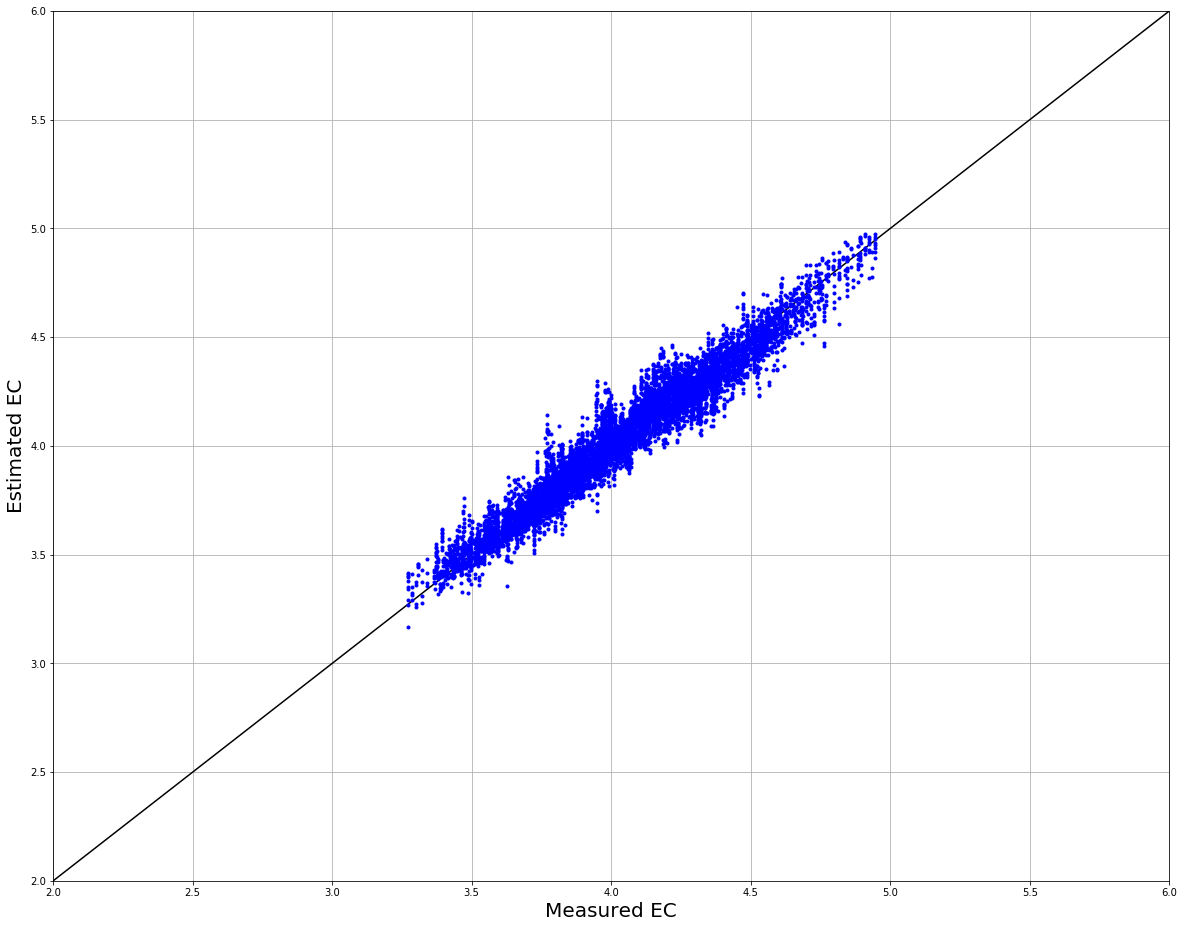

In [17]:
#1:1 graph
x_t = np.arange(-5, 10)
y_t = x_t

xny = plt.plot(x_t,y_t,'k')

expect1 = plt.plot(test_label, estimation, 'b.')

plt.axis([2, 6, 2, 6])
plt.grid(True)
plt.xlabel('Measured EC', {'fontsize':20})
plt.ylabel('Estimated EC',  {'fontsize':20})
#plt.legend([expect1], ["Mg"], prop={'size': 12})
plt.show()

In [18]:
regression_output = np.concatenate((test_label.T, estimation.T), axis=0).T

file_name = "regression_output_" + explanation + ".CSV"
np.savetxt("./Results/" + file_name, regression_output, delimiter=",")

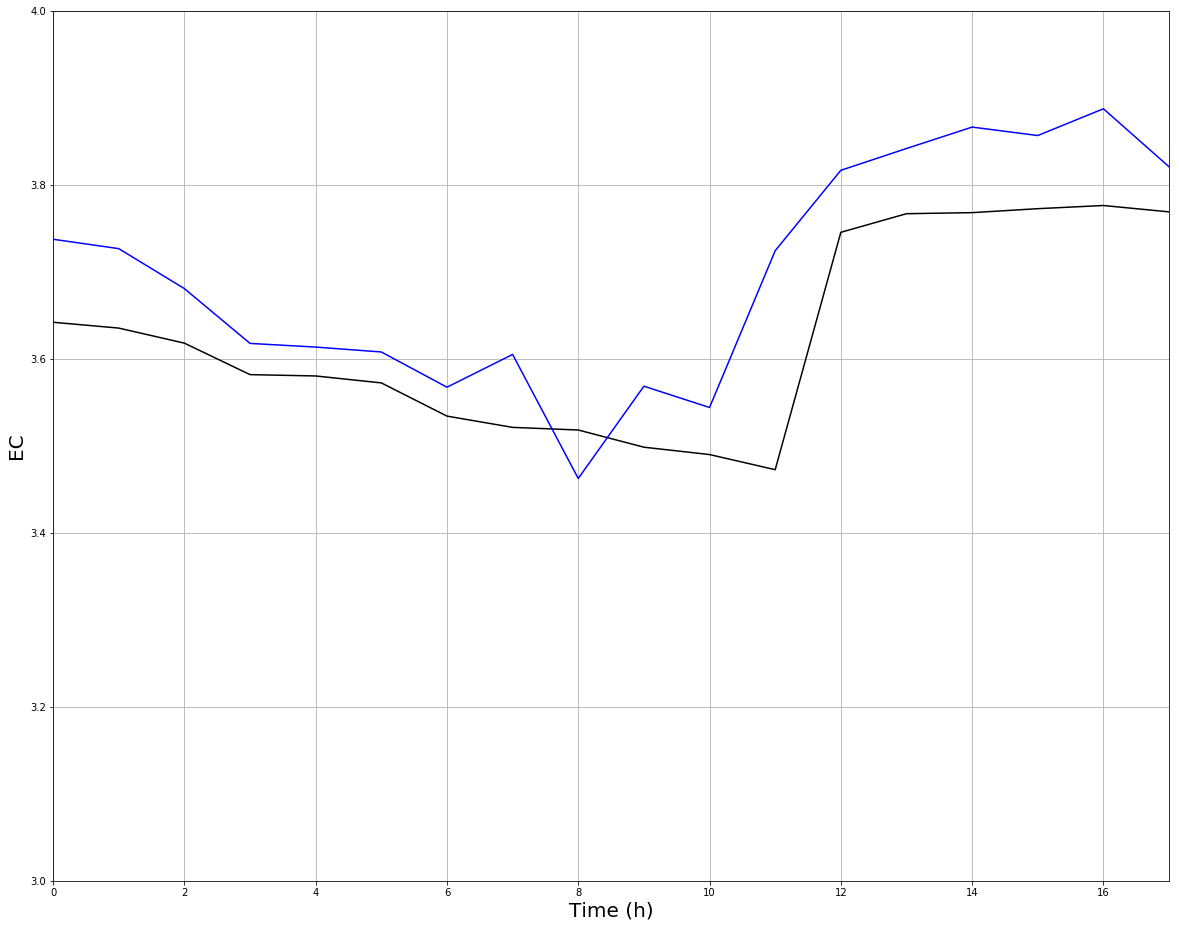

In [19]:
#chronological graph
x_t = np.arange(0, n_output)

measured1 = plt.plot(x_t, test_label[55,:].T, 'k') #estimated

expect1 = plt.plot(x_t, estimation[55,:].T, 'b') #estimated



plt.axis([0, n_output-1, 3, 4])
plt.grid(True)
plt.xlabel('Time (h)', {'fontsize':20})
plt.ylabel('EC',  {'fontsize':20})
plt.show()

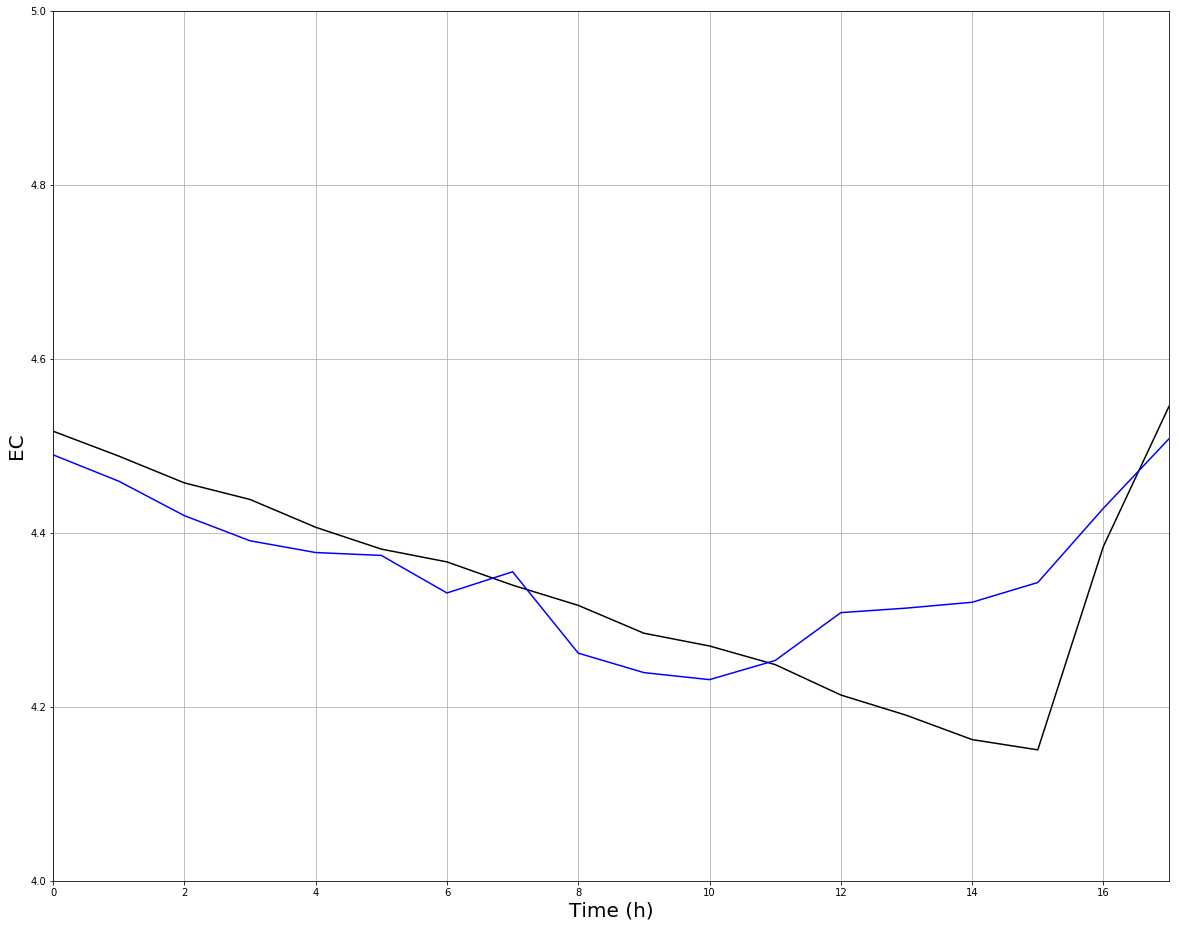

In [20]:
#chronological graph
i = 72
x_t = np.arange(0, n_output)

measured1 = plt.plot(x_t, test_label[i,:].T, 'k') #estimated

expect1 = plt.plot(x_t, estimation[i,:].T, 'b') #estimated



plt.axis([0, n_output-1, 4, 5])
plt.grid(True)
plt.xlabel('Time (h)', {'fontsize':20})
plt.ylabel('EC',  {'fontsize':20})
plt.show()

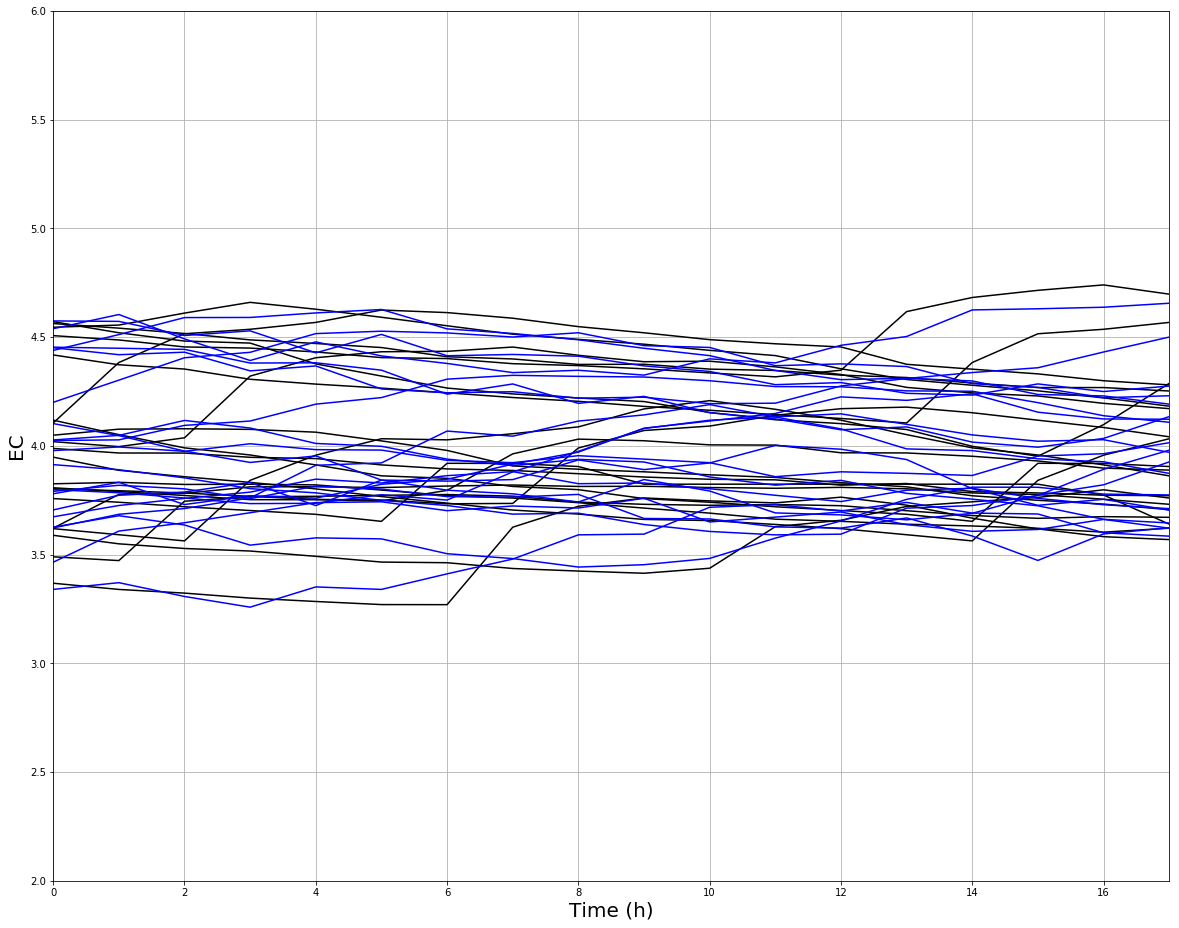

In [21]:
#chronological graph
x_t = np.arange(0, n_output)

measured1 = plt.plot(x_t, test_label[:20,:].T, 'k') #estimated
expect1 = plt.plot(x_t, estimation[:20,:].T, 'b') #estimated

plt.axis([0, n_output-1, 2, 6])
plt.grid(True)
plt.xlabel('Time (h)', {'fontsize':20})
plt.ylabel('EC',  {'fontsize':20})
plt.show()

In [22]:
# Load them!
l = np.load("./Data/ECpredset_wRWEC.npz")

# See what's in here
print (l.files)

# get data
pred_data = l['preddataset']
pred_label = l['predlabel']
n_pred = pred_label.shape[0]

print(pred_data[0])
print(pred_label[0])

print(pred_data.shape)
print(pred_label.shape)

['predlabel', 'preddataset']
[   4.509825      2.36598889    3.63195556   16.15047222   19.63758333
   13.21697222   67.13763889    4.470975      1.768         1.382         0.
    6.36231111    4.28258333    5.374425      5.23260278  150.
  408.34777778    0.           30.           12.355     ]
[ 4.48515278  4.46378611  4.44831667  4.42421667  4.40596667  4.37809167
  4.58665556  4.85048889  4.90490833  4.97277778  4.90884722  4.83730833
  4.75139167  4.71204167  4.66605556  4.62548056  4.5976      4.554325  ]
(3600, 20)
(120, 18)


In [23]:
#Processing

for i in range(pred_data.shape[1]):
    temp = pred_data[:,i]
    temp = (temp - mins[i]) / (maxs[i] - mins[i])
    pred_data[:,i] = temp

    
for i in range(pred_label.shape[1]):
    temp = pred_label[:,i]
    temp = (temp - labelmins[i]) / (labelmaxs[i] - labelmins[i])
    pred_label[:,i] = temp

In [24]:
pred_data = np.delete(pred_data, DELETE, axis=1)

In [25]:
print(pred_data[0])
print(pred_label[0])

[ 0.39660363  0.37346666  0.20244891  0.53094022  0.83060659  0.71674836
  0.53413897  0.44855566  0.06756757  0.21209254  0.53081761  0.36363636
  0.71393845  0.          0.23222229  0.24311295]
[ 0.72520933  0.7124582   0.70322641  0.68884409  0.67795292  0.66131778
  0.78578379  0.9432333   0.97570954  1.01621243  0.97806018  0.93536746
  0.88409442  0.86061126  0.83316784  0.80895364  0.79231518  0.76648968]


In [26]:
pred_data.shape

(3600, 16)

In [27]:
pred_x = pred_data.reshape((-1, n_steps, n_input))

print ("Prediction Accuracy:", sess.run(accuracy, feed_dict={x: pred_x, y: pred_label}))
prediction = sess.run(pred, feed_dict={x: pred_x, y: pred_label})

Prediction Accuracy: 0.680548


In [28]:
#Data restoring
for i in range(n_output):
    prediction[:,i] = (labelmaxs[i] - labelmins[i]) * prediction[:,i] + labelmins[i]
    pred_label[:,i] = (labelmaxs[i] - labelmins[i]) * pred_label[:,i] + labelmins[i]

print(prediction[0])
print(pred_label[0])

[ 4.46138668  4.46378708  4.44478798  4.48919106  4.52391577  4.51743984
  4.55610752  4.67057991  4.75040007  4.8238287   4.84458637  4.86179113
  4.82286692  4.82013702  4.72421789  4.73956537  4.64953423  4.63642693]
[ 4.48515278  4.46378611  4.44831667  4.42421667  4.40596667  4.37809167
  4.58665556  4.85048889  4.90490833  4.97277778  4.90884722  4.83730833
  4.75139167  4.71204167  4.66605556  4.62548056  4.5976      4.554325  ]


In [29]:
test_RMSE = np.sum(np.sqrt((pred_label - prediction)**2))/(prediction.shape[0]*18)

print("test RMSE: %.5f" % test_RMSE)

test RMSE: 0.09983


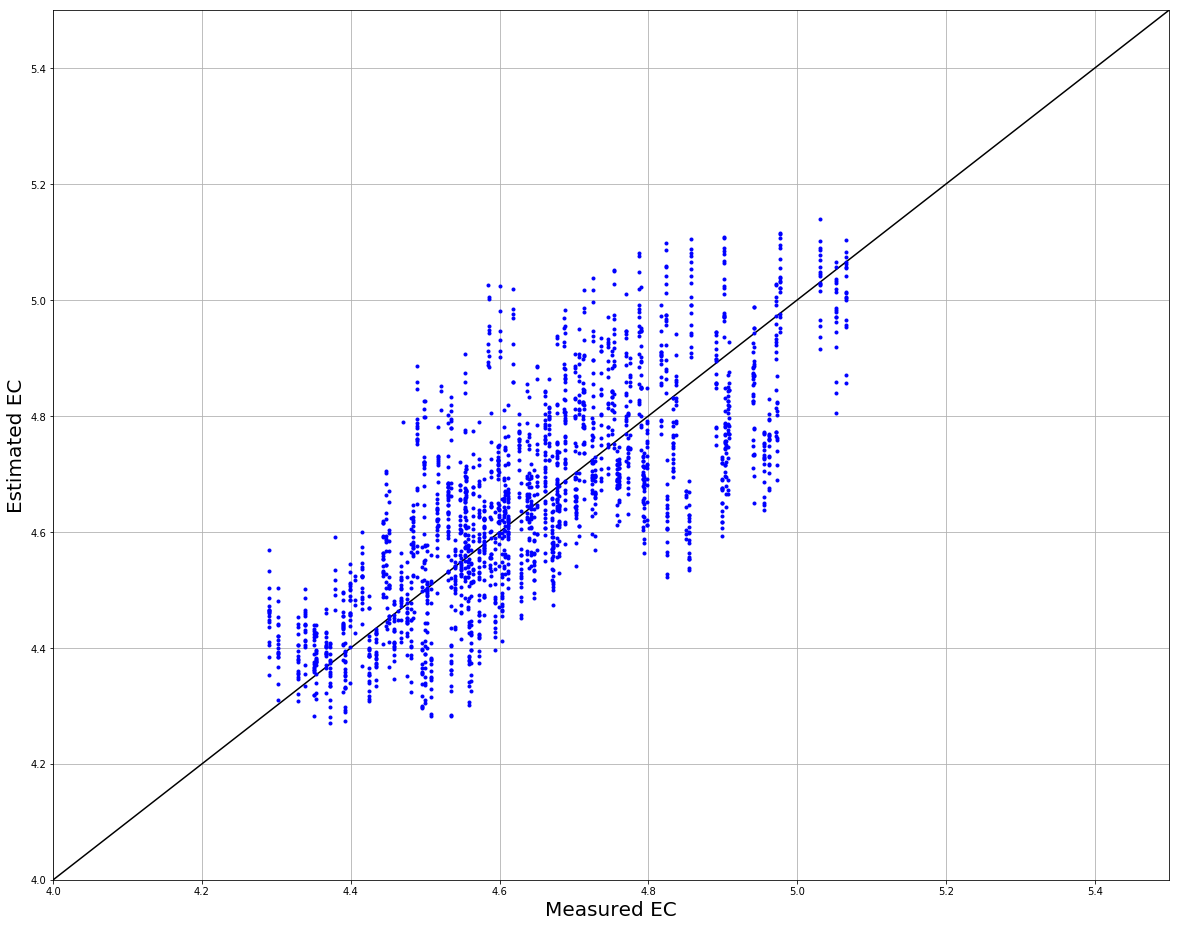

In [30]:
#1:1 graph
x_t = np.arange(-5, 15)
y_t = x_t

xny = plt.plot(x_t,y_t,'k')

expect1 = plt.plot(pred_label, prediction, 'b.')

plt.axis([4, 5.5, 4, 5.5])
plt.grid(True)
plt.xlabel('Measured EC', {'fontsize':20})
plt.ylabel('Estimated EC',  {'fontsize':20})
#plt.legend([expect1], ["Mg"], prop={'size': 12})
plt.show()

1 0.0509236929067
2 0.0672753152374
3 0.0808985704627
4 0.101668491799
5 0.0832763520877
6 0.101737436505
7 0.0999182964198
8 0.0977031245168
9 0.0982983599013
10 0.0914666915512
11 0.0965000092535
12 0.118051508272
13 0.105212530778
14 0.11920142409
15 0.106958751524
16 0.103127912944
17 0.141062782907
18 0.133571472972
[0.050923692906697557, 0.067275315237398436, 0.080898570462686115, 0.10166849179938989, 0.083276352087656727, 0.10173743650507046, 0.099918296419779506, 0.097703124516805046, 0.098298359901287033, 0.091466691551208554, 0.09650000925346662, 0.11805150827195915, 0.10521253077754265, 0.11920142409006761, 0.10695875152375969, 0.10312791294380474, 0.14106278290713281, 0.13357147297188099]


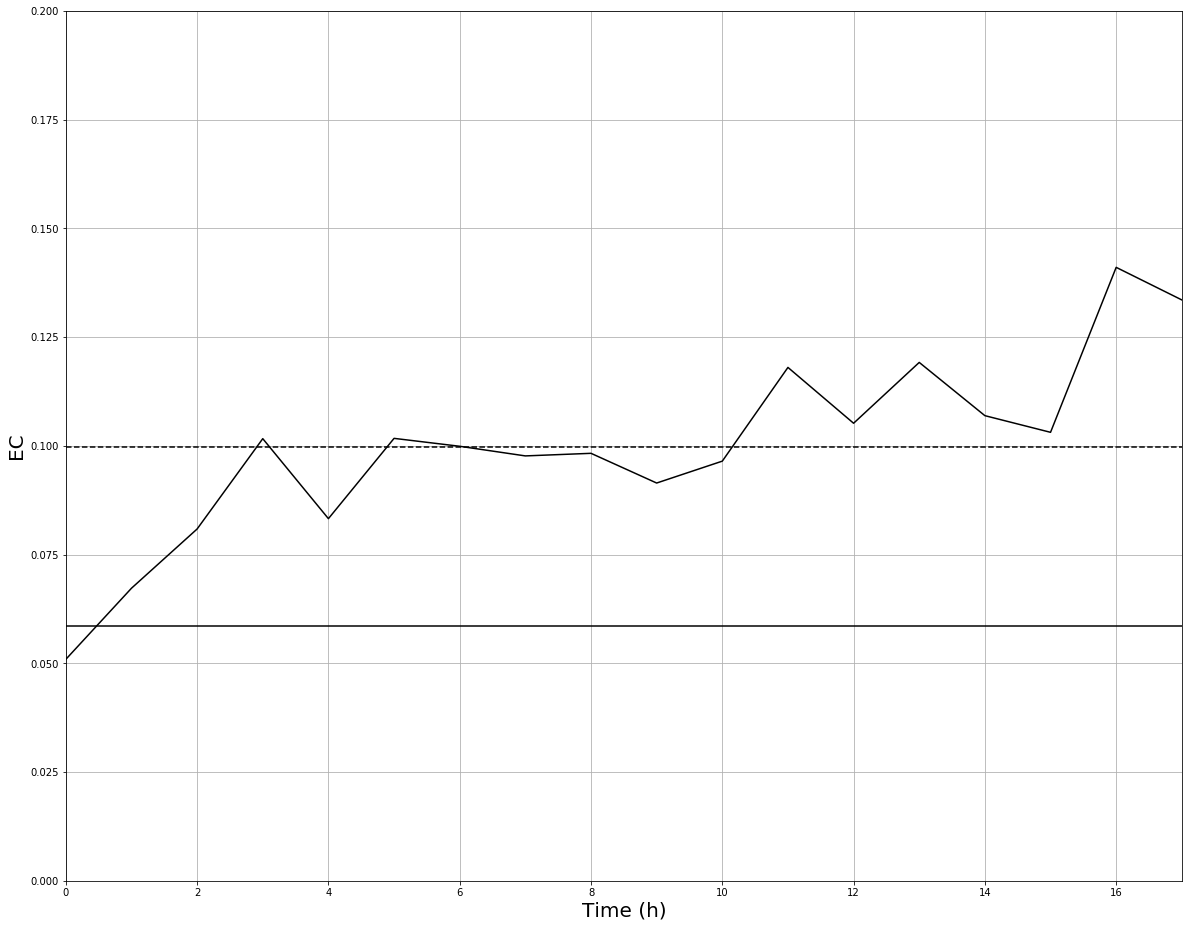

In [31]:
RMSE_data = []
for i in range(pred_label.shape[1]):
    k = np.sum(np.sqrt((pred_label[:, i] - prediction[:, i])**2))/120
    print(i+1, k)
    RMSE_data.append(k)
print(RMSE_data)


x_t = np.arange(0, 18)
y_t = x_t*0 + test_RMSE
y2_t = x_t*0 + valid_RMSE

RMSEs = plt.plot(x_t,RMSE_data, 'k')
test_RMSE = plt.plot(x_t, y_t, 'k--')
valid_RMSE = plt.plot(x_t, y2_t, 'k-')

plt.axis([0, 17, 0, 0.2])
plt.grid(True)
plt.xlabel('Time (h)', {'fontsize':20})
plt.ylabel('EC',  {'fontsize':20})
plt.show()

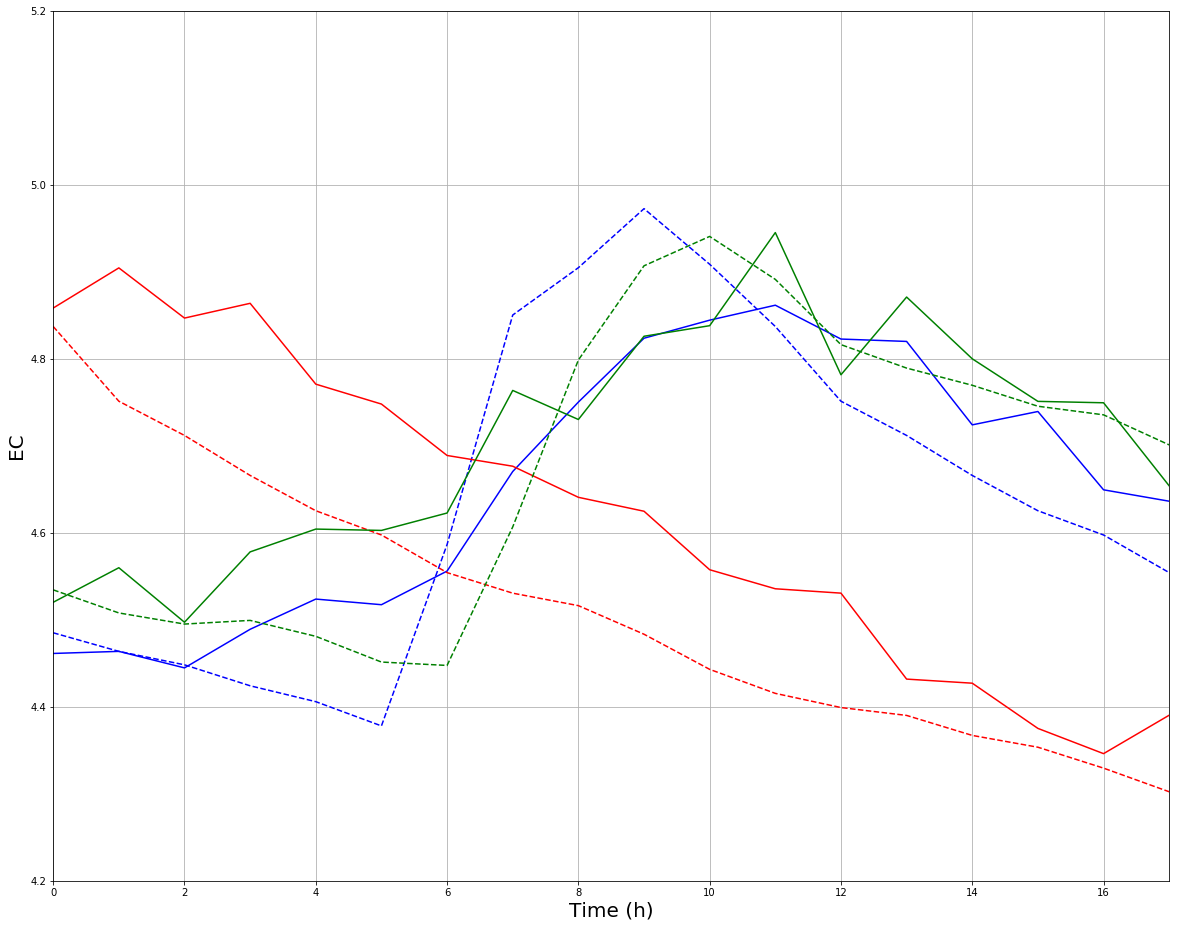

In [32]:
#chronological graph
i = 0
j = 11
k = 72
x_t = np.arange(0, 18)


expect1 = plt.plot(x_t, prediction[i,:].T, 'b') #estimated
measured1 = plt.plot(x_t, pred_label[i,:].T, 'b--') #estimated

expect2 = plt.plot(x_t, prediction[j,:].T, 'r') #estimated
measured2 = plt.plot(x_t, pred_label[j,:].T, 'r--') #estimated

expect3 = plt.plot(x_t, prediction[k,:].T, 'g') #estimated
measured3 = plt.plot(x_t, pred_label[k,:].T, 'g--') #estimated


plt.axis([0, 17, 4.2, 5.2])
plt.grid(True)
plt.xlabel('Time (h)', {'fontsize':20})
plt.ylabel('EC',  {'fontsize':20})
plt.show()

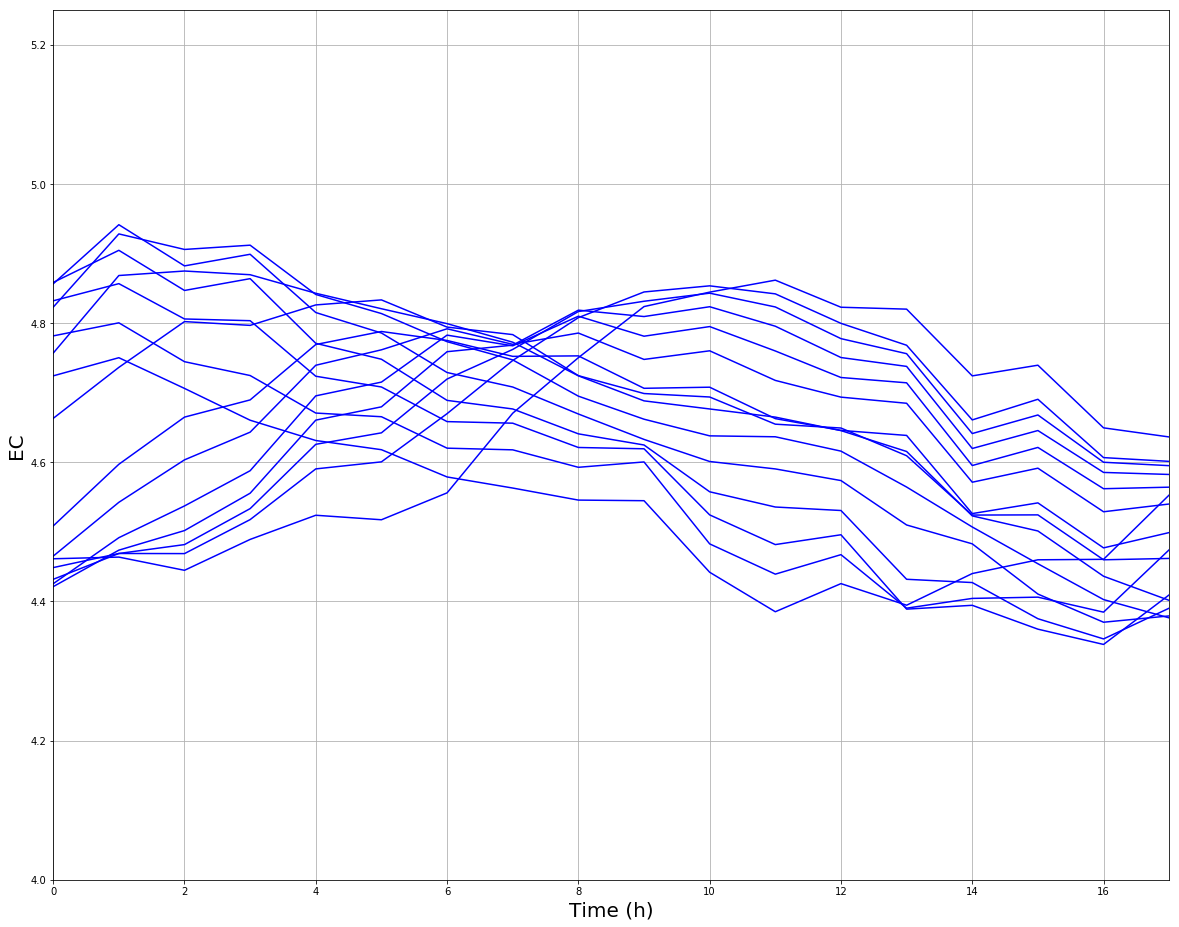

In [33]:
#chronological graph
x_t = np.arange(0, 18)

#measured1 = plt.plot(x_t, pred_label[:,:].T, 'k') #estimated
expect1 = plt.plot(x_t, prediction[:15,:].T, 'b') #estimated

plt.axis([0, 17, 4, 5.25])
plt.grid(True)
plt.xlabel('Time (h)', {'fontsize':20})
plt.ylabel('EC',  {'fontsize':20})
plt.show()

In [34]:
regression_output = np.concatenate((pred_label.T, prediction.T), axis=0).T

file_name = "pred_output_" + explanation + ".CSV"
np.savetxt("./Results/" + file_name, regression_output, delimiter=",")

In [35]:
sess.close()